# 3.2 Develop the regression model

In [1]:
# for the sake of development, use this magic command to solve slow suggestion
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 50)
from load_data import load_data
from preprocess_data import preprocess

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

#### Load in the dataset

In [3]:
df = preprocess(load_data())
df.head()

,revenue,runtime,num_prods,num_languages,num_writers,UNRATE,PCE,class,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,...,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
0,2.215460e+08,81.0,1,1,5,5.5,5013.9,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.250232,0.525304,0.652182,0.822822,1.051268,1.429510,0.393048,1.280904,2.228754
1,1.562650e+08,104.0,4,2,3,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.587154,0.471732,0.260389,0.629817,0.876776,1.069668,0.318272,1.090399,1.608897
2,4.843322e+07,127.0,1,1,2,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,6.978361,0.725830,-0.175874,0.146438,0.524006,0.754578,0.199206,0.969789,1.073962
3,1.114540e+08,170.0,3,2,1,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1.0,7.552392,0.962985,0.485863,0.962985,1.037811,1.211307,0.914079,1.364620,2.486659
4,3.191459e+07,127.0,7,2,5,5.6,5097.5,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1.0,7.537669,0.031408,0.337858,0.350829,0.858918,1.054498,0.697142,1.020292,1.228185


## 1. Regression

Develop the regression model for predicting the revenue that a film will make. We will actually predict $log_{10}$ of the revenue, and then transform it back.

### 1.1. Preparing the data

The first steps are to split the data into the train and test set. Do this with the methods that come with sklearn and set the training set to 80% of the total. The data will then need to be scaled. A min-max scaler was chosen for this. The target variable was transformed as $x\to\log_{10}x$.

In [4]:
X = df.drop(['revenue', 'class'], axis=1)
y = df['revenue'].apply(lambda x: math.log10(x))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
X_train.head(3)

,runtime,num_prods,num_languages,num_writers,UNRATE,PCE,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,...,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
492,129.0,4,1,3,9.3,2026.3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,6.865756,0.258398,0.341764,0.579441,1.014437,1.261239,0.798582,1.156781,1.614598
485,93.0,2,3,5,5.0,5494.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.0,7.721084,0.292256,0.434622,0.425045,0.377367,0.567262,0.169380,0.849092,1.104245
1217,94.0,3,2,1,8.3,1970.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1.0,6.161265,0.146128,-0.330993,0.146128,-0.114450,-0.069051,-0.213249,0.420781,-0.299316


In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

### 1.2 Training the models

The four models that will be trained be trained are a Linear Regression, a Support Vector Machine, a Decision Tree and a Random Forest. Default parameters are used for this first step of training, except for the SVM. The first step is put the models through a $K$-fold cross-validation for RMSE. Then test data is then scaled with a min-max scaler and used by the models to make predictions. Metrics are printed out for assessment.

In [8]:
lin_reg = LinearRegression()
svm_reg = SVR()
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()

#### $K$-fold cross-validation

In [9]:
scores_list = []
for clf in [lin_reg, svm_reg, tree_reg, forest_reg]:
    print(type(clf))
    scores = cross_val_score(clf, X_train, y_train,
                             scoring='neg_root_mean_squared_error', cv=10)
    scores_list.append(scores)
#     print(scores)
    print("rmse mean: {:.4f}".format(-scores.mean()))
    print("rmse std dev: {:.4f}".format(scores.std()))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
rmse mean: 0.6012
rmse std dev: 0.0409

<class 'sklearn.svm._classes.SVR'>
rmse mean: 0.6027
rmse std dev: 0.0410

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
rmse mean: 0.8693
rmse std dev: 0.0284

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
rmse mean: 0.6063
rmse std dev: 0.0432



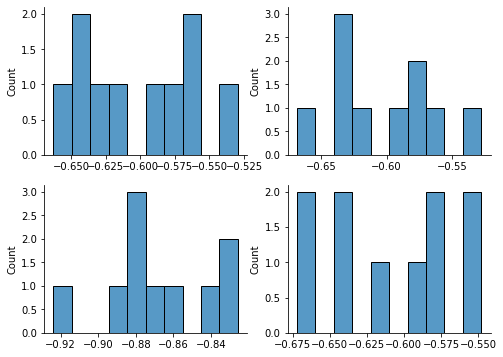

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.histplot(scores_list[0], ax=ax[0][0], bins=10)
sns.histplot(scores_list[1], ax=ax[0][1], bins=10)
sns.histplot(scores_list[2], ax=ax[1][0], bins=10)
sns.histplot(scores_list[3], ax=ax[1][1], bins=10)
sns.despine(right=True)
plt.show()

#### Training on the full set - predict test and output scores

In [11]:
X_test = scaler.fit_transform(X_test)

In [12]:
for reg in [lin_reg, svm_reg, tree_reg, forest_reg]:
    reg.fit(X_train, y_train)
    preds = (reg.predict(X_test))
    print(f'Model scoring: {type(reg)}')
    print("r2-score = {:.4f}".format(r2_score(y_test, preds)))
    print("mse = {:.4f}".format(mean_squared_error(y_test, preds)))
    print("rmse = {:.4f}".format(math.sqrt(mean_squared_error(y_test, preds))))
    print()

Model scoring: <class 'sklearn.linear_model._base.LinearRegression'>
r2-score = -28304237628503313350656.0000
mse = 21720958038991240691712.0000
rmse = 147380317678.4174

Model scoring: <class 'sklearn.svm._classes.SVR'>
r2-score = 0.5008
mse = 0.3831
rmse = 0.6189

Model scoring: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
r2-score = -0.1659
mse = 0.8948
rmse = 0.9459

Model scoring: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
r2-score = 0.4750
mse = 0.4029
rmse = 0.6347



In [16]:
print("${:.2f}".format(10 ** preds[2]))
print("${:.2f}".format(10 ** y_test.iloc[2]))

$957691.13
$4732801.62


### 1.3 Taking models forward for tuning

We can see that the linear regression was wildly unstable. The two best performing of the remaining three were the random forest and SVM, just like for the classification problem.

#### 1.3.1 Random Forest Tuning

In [17]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
param_grid = {
    'n_estimators': [100, 200, 500]
    , 'max_features': ['auto', 'sqrt', 'log2']
    , 'max_depth' : [100, 200, 500]
    , 'oob_score': [True, False]
}

forest_reg = RandomForestRegressor()

r2 = make_scorer(r2_score)  

forest_grid = GridSearchCV(forest_reg, param_grid, cv=5
                          , return_train_score=True
                          , scoring=r2, verbose=1)
forest_grid.fit(X_train, y_train)

print(forest_grid.best_estimator_)

print(forest_grid.best_score_)

predictions = (forest_grid.predict(X_test))
print(f'Model scoring: {type(forest_grid)}')
print(f"r2-score = {r2_score(y_test, predictions)}")
print(f"mse = {mean_squared_error(y_test, predictions)}")
print(f"rmse = {math.sqrt(mean_squared_error(y_test, predictions))}")
print()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 16.9min finished


RandomForestRegressor(max_depth=200, n_estimators=500)
0.517675583658028
Model scoring: <class 'sklearn.model_selection._search.GridSearchCV'>
r2-score = 0.481277468939574
mse = 0.39807291328336103
rmse = 0.6309301968390489



#### 1.3.2 Support Vector Machine

In [20]:
svm_reg.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [21]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    , 'gamma': ['scale', 'auto']
    , 'C': [1.0, 2.0, 5.0]
}

svm_reg = SVR()

r2 = make_scorer(r2_score)  

svm_grid = GridSearchCV(svm_reg, param_grid, cv=5
                          , return_train_score=True
                          , scoring=r2, verbose=1)
svm_grid.fit(X_train, y_train)

print(svm_grid.best_estimator_)

print(svm_grid.best_score_)

predictions = (svm_grid.predict(X_test))
print(f'Model scoring: {type(svm_grid)}')
print(f"r2-score = {r2_score(y_test, predictions)}")
print(f"mse = {mean_squared_error(y_test, predictions)}")
print(f"rmse = {math.sqrt(mean_squared_error(y_test, predictions))}")
print()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.7min finished


SVR(C=5.0, gamma='auto')
0.5163981271272281
Model scoring: <class 'sklearn.model_selection._search.GridSearchCV'>
r2-score = 0.5007443114463213
mse = 0.3831338615840884
rmse = 0.6189780784358105

